# **Homework 1 - Event Detection** 

> The notebook has been written in *Google Colab* and all my implemented files are inside the ***hw1/stud/src*** folder. All the files that I used for the training (embeddings, vocabularies etc.) can be downloaded from this [link](https://drive.google.com/drive/folders/1pCGvcmo1VdU5UjgKM9DSyZcPBXIakMC2?usp=sharing) (if needed). Of course, all the files that are required by my best *StudentModel* model for the prediction phase (as explained in the homework instructions) are in *model* folder.

> If you want to start a *training*, you simply need to first call ***build_dataset_pipeline()*** function in *Dataset* section and then ***training_pipeline()*** in *Training* section!

**Setting up**

In [ ]:
!git clone https://github.com/lavallone/NLP.git

In [ ]:
!cp -r /content/drive/MyDrive/NLP/HW_01/model NLP/HW_01
!mkdir NLP/HW_01/model/checkpoints
%cd /content/NLP/HW_01

## Imports & Downloads

In [ ]:
# download the missing packages
!pip install scikit-learn > /dev/null
!pip install seqeval > /dev/null
!pip install matplotlib > /dev/null
!pip install wandb > /dev/null
!pip install spacy > /dev/null
!python -m spacy download en_core_web_sm > /dev/null

In [ ]:
# import stuffs
from hw1.stud.src.data import EventDetDataset, clean_tokens, filter_sentences, pos_tagger
from hw1.stud.src.hyperparameters import Hparams
from hw1.stud.src.train import Trainer
from hw1.stud.src.models import EventDetModel, predict_function
from hw1.stud.src.utils import three_group_bar, plot_histogram, evaluation_pipeline

import torch
from torch import nn
from torch.utils.data import DataLoader
from collections import OrderedDict, Counter
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# to have a better workflow using python notebooks
%load_ext autoreload
%autoreload 2

In [ ]:
# setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(537)

## Look at the data! 👀

The first thing to do before starting a new deep learning project is to look at the data! Without a quality dataset there's no way of achieving good results. In our case, the given dataset is quite *clean* and does not required much work but anyway there's always room for improvement.

A first check that's needed is to look at the data distribution. In the sense that *train*, *val* and *test* sets must have the same labels distribution. Otherwise all the future experiments will be meaningless and ineffective.

In [ ]:
hparams = Hparams()
data_train = [json.loads(e) for e in open(hparams.data_train, "r")]
data_val = [json.loads(e) for e in open(hparams.data_val, "r")]
data_test = [json.loads(e) for e in open(hparams.data_test, "r")]

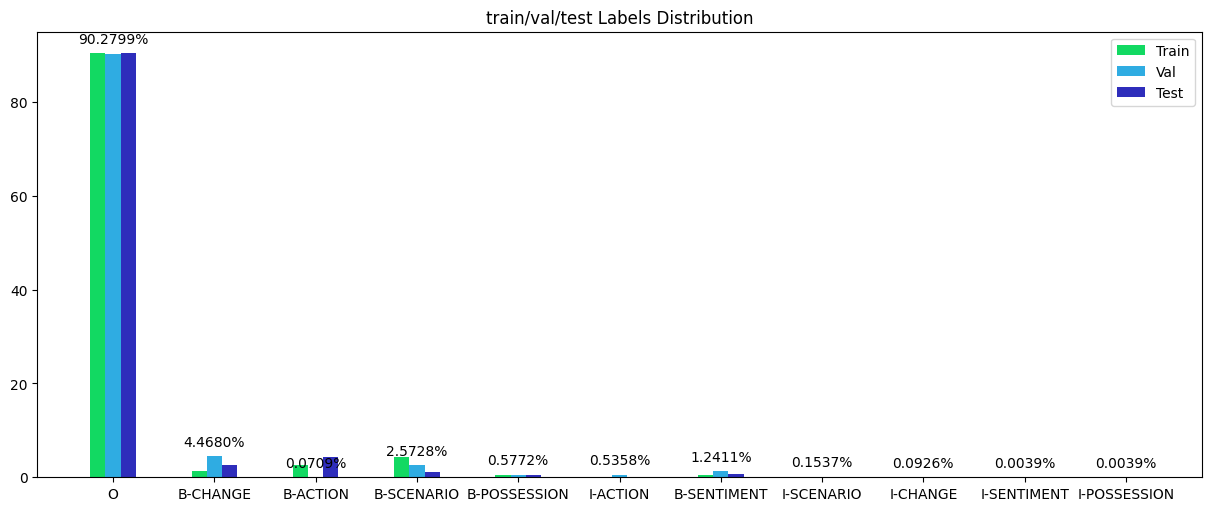

In [ ]:
data = []

# TRAIN
c = Counter([e for sublist in [d["labels"] for d in data_train] for e in sublist])
l = list(c.values())
tot = 0
for v in l:
    tot += int(v)
for i in range(len(l)):
    l[i] = (l[i]/tot)*100
data.append(l)

# VAL
c = Counter([e for sublist in [d["labels"] for d in data_val] for e in sublist])
l = list(c.values())
tot = 0
for v in l:
    tot += int(v)
for i in range(len(l)):
    l[i] = (l[i]/tot)*100
data.append(l)

# TEST
c = Counter([e for sublist in [d["labels"] for d in data_test] for e in sublist])
l = list(c.values())
tot = 0
for v in l:
    tot += int(v)
for i in range(len(l)):
    l[i] = (l[i]/tot)*100
data.append(l)

columns = list(c.keys())
three_group_bar(columns, data, "train/val/test Labels Distribution")

As we can see above the three distribution are quite similar and is pretty evident how the "*O*" label is the most dominant one. Hence, we are dealing with an *unbalanced* dataset and in fact all the choices that I've made during the development path of the project were selected to address this problem. <br> The context setting is low and for each sentence there are no many words to help the model to predict the events. For this reason, in my opinion, has been crucial to first **clean the tokens** from any dirtiness and create new and smart ones and secondly to **build a vocabulary** by generating as few *OOV* words as possible because any word is precious in a task like this.

### Clean tokens 🧹

As I 've already said, the dataset wasn't looking too bad, but some *cleaning* operations were needed to achieve better results on the task. <br> The choices made at this step had two different aims: 
* simple *cleaning* of tokens from weird symbols, punctuations, UNICODE characters and so on;
*  *definition* of new tokens with the hope of helping the model to make good predictions based on their position and context.

> 🔸 The function I implemented is "*clean_tokens*" from the *data.py* file and below I'll described the most significant changes that I executed. Of course, this function is applied to all the dataset splits (*train/val/test*).

In [ ]:
# this is simply how you perform the cleaning
train_sentences = [e["tokens"] for e in data_train]
clean_tokens(train_sentences)

🗒 Basic ***clean_tokens*** steps:
*  in the dataset were often present this kind of misprint character sequence ["<", "ref", "name=", "''", "AAIB_8/88", "''", ">"] that I decided to not consider;
* for dealing with situations like the one above, I introduced a new token *\<IGNORE\>* hoping that the system would ignore it at prediction time. I also defined a set of punctuations/symbols to be substituted by this new token;
* besides the fact of mapping the digit numbers from 0 to 10 to their string version ("2" ➡ "two"), I introduced an other new token *\<NUMBER\>* for all the numbers that appeared in the dataset. This choice has been made for treating all the numbers at the same level of contextual importance;
* a subset of punctuations/symbols that constituted a single token (the ones contained as a part of other words were simply deleted) were left untouched and considered as standalone tokens;
* all the tokens were lower-cased, I deleted all the unicode characters (e.g. *\u00f* ), I substituted all the types of brackets to the round ones and all this type of quotes " ` " to this one " ' ". I replaced "&" with "and" and kept the saxon genitive " 's " as a single token. 

### Build Vocabulary

Since we are going to leverage an architecture with the *embedding layer* at the beginning, we need to decide which **word embedding** to use. It's quite clear that by using it the performance of the model will increase. <br> *Word2Vec* was a possible choice but it generated, according to me, too many *OOV* words and *fastText* was maybe the best choice (many people tell so) but dealing with subwords embeddings was not the best idea. I therefore decided to use **GloVe**. I had three options from the Stanford website but at the end I decided to download "***glove.6B.zip***" because is *uncased*, it has a relatively small vocabulary size (*400K*) with respect to other options but big enough for my purposes and it has four different word embedding sizes (50, 100, 200 and 300) for making experiments. 
> *The **300** embedding size will perform better on my models!*

In [ ]:
# download GloVe pretrained embeddings
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip ../../model/glove.6B.zip

So the starting vocabulary will be the one implicitly defined by the GloVe files.

In [ ]:
def build_glove_vocab(glove_file, emb_size=300):
    word2id = OrderedDict()
    id2emb = OrderedDict()
    id = 0
    for l in open(glove_file, "r"):
        line = l.split(" ")
        word = line[0]
        emb = np.asarray(line[1:], dtype="float64")
        word2id[word] = id
        id2emb[id] = emb
        id += 1
    return word2id, id2emb

In [ ]:
glove_file = "model/glove/glove.6B.300d.txt"
word2id, id2emb = build_glove_vocab(glove_file)

> Since I introduced two new tokens ***\<IGNORE\>*** and ***\<NUMBER\>*** and I don't want to lose any information that can be used to benefit events prediction, I need to extend the vocabulary. I first have to select the most frequent words which are in my training set but not in the vocabulary and then add them to it.

In [ ]:
# list of training OOV words
oov_list = []
for token in [e for sublist in [e["tokens"] for e in data_train] for e in sublist]:
    if token not in word2id and token not in oov_list:
        oov_list.append(token)

# count the frequencies of each OOV word
c = Counter([e for sublist in [e["tokens"] for e in data_train] for e in sublist if e in oov_list])
# show the 100 most common ones
c.most_common(100)

# as a design choice I decide to pick only the train OOV words which have a frequency higher or equal than 10!
words_to_add = []
for e in c.most_common(100):
    if e[1] >= 10:
        words_to_add.append(e[0])

['<NUMBER>', '<IGNORE>', 'saffirsimpson', 'yucatn', 'dtat', 'isil', 'trgesh']

In [ ]:
def build_extended_vocab(glove_file, words_to_add, emb_size=300):
    word2id = OrderedDict()
    id2emb = OrderedDict()
    tot, numbers_tot = np.zeros(emb_size, dtype="float64"), np.zeros(emb_size, dtype="float64")
    id, num = 0, 0
    for l in open(glove_file, "r"):
        line = l.split(" ")
        word = line[0]
        emb = np.asarray(line[1:], dtype="float64")
        if word.isnumeric():
            numbers_tot += emb
            num += 1
        word2id[word] = id
        id2emb[id] = emb
        tot += emb
        id += 1
    
    for w in words_to_add:
        word2id[w] = id
        if w=="<NUMBER>":
            emb = numbers_tot/num # average of all the numbers embeddings
            id2emb[id] = emb
            tot += emb
        else:
            emb = np.random.rand(emb_size) # random initialization of the embedding
            id2emb[id] = emb
            tot += emb
        id += 1

    word2id['<UNK>'] = id
    id2emb[id] = tot/id # average of the other embeddings
    word2id['<PAD>'] = id+1
    id2emb[id+1] = np.zeros(emb_size, dtype="float64")
    return word2id, id2emb

In [ ]:
glove_file = "model/glove/glove.6B.300d.txt"
word2id, id2emb = build_extended_vocab(glove_file, words_to_add)

In [ ]:
# if not already there, you can save the vocabulary in "model/files/vocabs" as "word2id.json"
json.dump(word2id, open("model/files/vocabs/word2id.json", "w"))

# if not already done, you can save the embedding layer in "model/embeddings/300" as "embedding_layer.pth"
embedding_layer = torch.nn.Embedding.from_pretrained(torch.from_numpy(np.vstack(list(id2emb.values()))))
torch.save(embedding_layer.state_dict(), "model/embeddings/300/embedding_layer.pth")

> 🔸 To check the goodness of my extended vocabulary and of the previous token cleaning process, I want to check if there are labeled *EVENTS* that are not present in the vocabulary (*OOV events*). If so, I'll intervene in some way.

In [ ]:
for sample in data_train:
    for i in range(len(sample["tokens"])):
        if sample["labels"][i] != "O" and sample["tokens"][i] not in word2id:
            print("OOV event detected!")
# it doesn't print anything, so we're OK!

> ⚡ **Embeddings strategy**: given that the "GloVe" embeddings are already pretrained and instead the new words that I added to the extended version of it are randomly initialized, it made sense to me to differentiate their training behaviour. In fact, if the *hyperparameter* ***num_emb*** is set to 2, we have the option to stop the finetuning process of the pretrained GloVe embeddings after **stop_train_emb** epochs while  continuing the training of the "added" embeddings. For this purpose, in practice, we have to "split" the vocabulary and create two separate embedding layers.


In [ ]:
## GloVe embeddings
id2emb_1 = {k:v for k,v in id2emb.items() if k<400000}
# if not already done, you can save the embedding layer in "model/embeddings/300" as "embedding_layer_1.pth"
embedding_layer_1 = torch.nn.Embedding.from_pretrained(torch.from_numpy(np.vstack(list(id2emb_1.values()))))
torch.save(embedding_layer_1.state_dict(), "model/embeddings/300/embedding_layer_1.pth")

## new added embeddings
id2emb_2 = {str(int(k)-400000):v for k,v in id2emb.items() if k>=400000}
# if not already done, you can save the embedding layer in "model/embeddings/300" as "embedding_layer_2.pth"
embedding_layer_2 = torch.nn.Embedding.from_pretrained(torch.from_numpy(np.vstack(list(id2emb_2.values()))))
torch.save(embedding_layer_2.state_dict(), "model/embeddings/300/embedding_layer_2.pth")

### Filter Sentences 🥅

Another important step before finishing the preprocessing part, is to filter out the *training* sentences. This is something it has to be done only at training time because the test/val datasets don't have to be touched in this sense. <br> Let's first see which is the histogram of sentences length.

LENGHT SENTENCES STATISTICS:
| mean: 25.64275
| std: 12.48271294380753
| min: 1
| max: 343


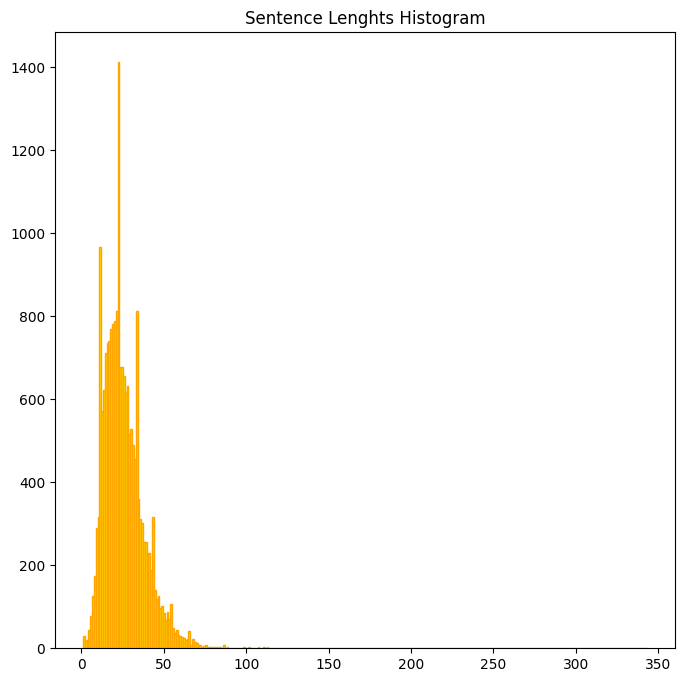

In [ ]:
sent_lengths_list = [len(e) for e in train_sentences]
plot_histogram(sent_lengths_list)

As we can see there are some "sentence *outliers*" which deviates from the majority of data and this is not good in machine learning because our aim is always to learn a data distribution. Actually the mean value is 25, but we have the maximum sentence length that reaches 343. This kind of training samples have to be avoided in order to not make the model learn other type of distribution. <br> Saying that, the first step to do is to filter sentences based on their length. I've choosen to set *min_sent_length=2* and *max_sent_length=60* as length bounds and they appeared to work pretty good. Other type of sentences that I wanted to delete from the train set, as not useful for the prediction process, were the ones with no "*EVENTS*", i.e. labels with all "*O*".

LENGHT SENTENCES STATISTICS:
| mean: 25.37460212929426
| std: 10.714023826048471
| min: 3
| max: 59


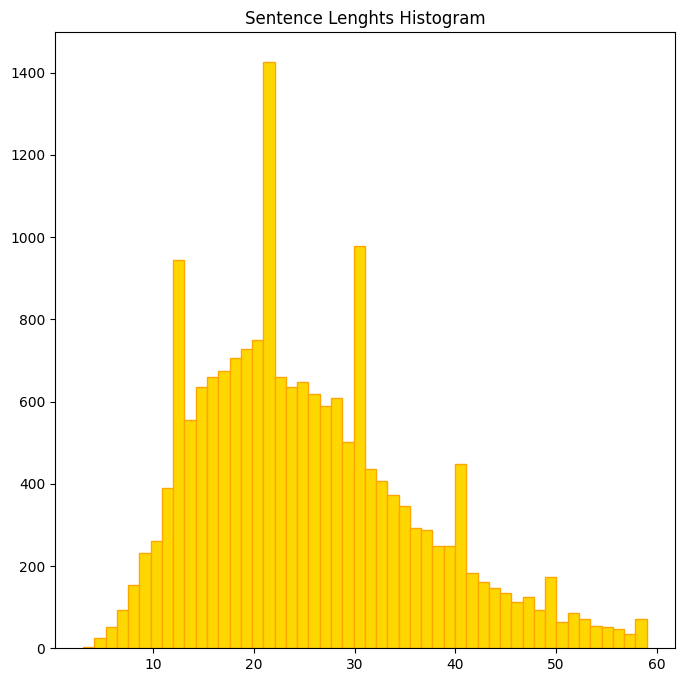

In [ ]:
train_sentences, train_labels = filter_sentences([e["tokens"] for e in data_train], [e["labels"] for e in data_train], word2id)
sent_lengths_list = [len(e) for e in train_sentences]
plot_histogram(sent_lengths_list)

> 🔸 Look now how good the shape is looking! Only *9%* of sentences are excluded (1778 sentences). The function I implemented to do this filtering is "*filter_sentences*" from the *data.py* file and is only applied to *training* data.

## Models

The adviced model architecture is a simple composition of an **Embedding layer**, a **Sequence encoder** and at the end a **Classifier**. <br> What I've implemented for this homework:
* *nn.Embedding* pytorch module to work as a lookup table with pretrained GloVe embeddings and additional embeddings. Possibility of split the embeddings to have two different ways of being trained.
* *nn.LSTM* pytorch architecture was the immediate choice. I didn't try other *RNNs-like* architectures as *GRU* for example because honestly since the beginning I achieved good results and therefore I decided to focus on *hyperparameters tuning* (using *Sweep* feature of  WandB). Without *LSTM*, it would have been impossible to encode information about the context of words (basic for our task) and it's probably the main block of the model. With respect to *vanilla RNNs*, it overcomes the vanishing gradient problem and it most robust to long term dependencies between words. One of its greatest power is the possibility of encoding the sequence both from *left-to-right* and *from right-to-left* to further enhance contextualization (***Bi-LSTMS***). To increase the performance I played and tweaked with *hidden_dim*, *bidirectional* and *num_layers* hyperparameter values.
* *nn.Linear* is the simplest classifier to use. I also implemented a *MLP classifier* with three layers and ReLu activation functions, but with poor results. Therefore I used the simplest version which performed better and has moreover less weights to train.

### ⚡ EXTRAS 

During the very first experiments I noticed that for the system was especially hard to predict correctly the "*inside*" tags. Reasoning about it, this can be due  to the scarcity of these type of labels. In fact, with  respect to the "*begin*" tags, they are really a lot fewer (see the first plot of labels distribution). But anyway, I approach this issue and tried to solve it. 

* The first idea was to sum to the word embeddings, as it happens in *Transformer* models, a **positional encoding**. In order to convey to the model a sort of knowledge about where the tokens are within the sequence. For example if the prediction is "*B-ACTION*" at position *i*, the system should understand that the probability that "I-ACTION" is at *i+1* is higher than position *i-1*. It didn't work as expected: maybe because the positional encoding expresses its full potential in the moment in which *attention* in involved. 
* The second idea was to leverage **POS tags**. This because I noticed that most of the time the *events* are verbs (VERB) and I thought that giving the model an information like this it would have helped it. However I think that giving POS tags is in general benefitting the overall system since it can learn or extrapolate underlying grammatical relations which I could never have noticed. *How to provide/combine them with the model?* I tried and thought many options but at the end the most intuitive one is the following: after computing the POS tags of the input sequence, I embed it in a simply *Embedding layer*, I then sum the result to the *LSTM output* and finally feed it to a *Linear layer* which learns to compute the best way (hopefully) of combining them. 

### Baseline

<br>
<table>
  <tr>
    <th><center>hparams</center></th>
    <th><center> </center></th>
  </tr>
  <tr>
    <td><center>load_pretrained_emb</center></td>
    <td><center>False</center></td>
  </tr>
    <tr>
    <td><center>hidden_dim</center></td>
    <td><center>512</center></td>
  </tr>
    <tr>
    <td><center>bidirectional</center></td>
    <td><center>False</center></td>
  </tr>
    <tr>
    <td><center>num_layers</center></td>
    <td><center>1</center></td>
  </tr>
   <tr>
    <td><center>dropout</center></td>
    <td><center>0</center></td>
  </tr>
    <tr>
    <td><center>⚡ POS_emb</center></td>
    <td><center>False</center></td>
  </tr>
    <tr>
    <td><center>⚡ positional_encode</center></td>
    <td><center>False</center></td>
  </tr>
 

</table>
<br>

## Dataset

> ⚡ **Mix windows strategy**: since we are processing our dataset using a *sliding window* mechanism, why limit us by only using a single *window_size/window_shift* pair at training time? I firmly think that by varying this two hyperparameters at training time, a greater generalization power is transferred to the model. If you think about that, is not only a matter of words dependencies length, but it is moreover a matter of the different and heterogeneous contexts (w.r.t. a token) the system sees each training step to make predictions. I hope this will help my model to improve the performance in the *SECRET* test set. As it can be seen below, to implement the strategy, I prepared a list containing 10 different dataloaders ready to be inputted to the training pipeline.


Additionally, at *testing* time one can play with the *window_shift* parameter and leverage the capability of predicting "overlapped" sections of sequences (*see "manipulate_preds()" function in "models.py"*). This because I implemented a prediction logic through which I can deal with overlapped segments and it conveys a sort of extra confidence (*see "overlap_preds()" function in "models.py"*). 

In [ ]:
def mix_windows_strategy(train_sentences, train_labels, pos_tokens, vocab, hparams):
    print(' ____________________________')
    print('| MIXING WINDOWS STRATEGY ON |')
    train_dataloader_list = []
    for i in range(10):
        hparams.window_size = random.randint(20, 50)
        hparams.window_shift = random.randint(int((hparams.window_size/2)+1), hparams.window_size)
        print(f"| #{i} | window_size: {hparams.window_size} | window_shift: {hparams.window_shift}")
        train_dataset = EventDetDataset(train_sentences, train_labels, pos_tokens, vocab, hparams, pred=False)
        train_dataloader_list.append(DataLoader(train_dataset, batch_size=hparams.batch_size, shuffle=True, num_workers=hparams.n_cpu, pin_memory=hparams.pin_memory, persistent_workers=True, collate_fn=EventDetDataset.collate_batch))
    print()
    return train_dataloader_list

In [ ]:
def build_dataset_pipeline(hparams):
    vocab = json.load(open(hparams.vocab_path, "r"))
    # TRAIN
    data_train = [json.loads(e) for e in open(hparams.data_train, "r")]
    train_sentences = [e["tokens"] for e in data_train]
    train_labels = [e["labels"] for e in data_train]
    clean_tokens(train_sentences)
    train_sentences, train_labels = filter_sentences(train_sentences, train_labels, vocab)
    train_pos_tokens = None
    if hparams.POS_emb:
        train_pos_tokens = pos_tagger(train_sentences)
        print("| TRAIN POS TAGS extracted! |\n")
    train_dataset = EventDetDataset(train_sentences, train_labels, train_pos_tokens, vocab, hparams, pred=False)
    train_dataloader = DataLoader(train_dataset, batch_size=hparams.batch_size, shuffle=True, num_workers=hparams.n_cpu, pin_memory=hparams.pin_memory, persistent_workers=True, collate_fn=EventDetDataset.collate_batch)
    train_dataloader_list = None
    if hparams.change_window_each_epoch != -1:
        train_dataloader_list = mix_windows_strategy(train_sentences, train_labels, train_pos_tokens, vocab, hparams)

    # VAL
    data_val = [json.loads(e) for e in open(hparams.data_val, "r")]
    val_sentences = [e["tokens"] for e in data_val]
    val_labels = [e["labels"] for e in data_val]
    clean_tokens(val_sentences)
    val_pos_tokens = None
    if hparams.POS_emb:
        val_pos_tokens = pos_tagger(val_sentences)
        print("| VAL POS TAGS extracted! |\n")
    # we reset the default values we're going to use for validation phase
    hparams.window_size = 40
    hparams.window_shift = 40
    val_dataset = EventDetDataset(val_sentences, val_labels, val_pos_tokens, vocab, hparams, pred=False)
    val_dataloader = DataLoader(val_dataset, batch_size=hparams.batch_size, shuffle=False, num_workers=hparams.n_cpu, pin_memory=hparams.pin_memory, persistent_workers=True, collate_fn=EventDetDataset.collate_batch)

    return train_dataloader, train_dataloader_list, val_dataloader, val_dataset.windows_each_sentence_list

## Training ⛏

> Throughout all the project I used ***WandB*** as logging tool.

In [ ]:
def training_pipeline(config=None):
    hparams_tuning = False
    version_name = "BEST"
    with wandb.init(entity="lavallone", project="NLP", name=version_name, mode="online", config=config):
        seed = wandb.config.seed if hparams_tuning else 537
        set_seed(seed)
        hparams = Hparams()
        # when doing the hparams search, this is how each run we change them to search for the best combinations!
        if hparams_tuning:
            hparams.batch_size = wandb.config.batch_size
            hparams.dropout = wandb.config.dropout
            hparams.emb_dim = wandb.config.emb_dim
            hparams.lr = wandb.config.lr
            hparams.num_layers = wandb.config.num_layers
            hparams.hidden_dim = wandb.config.hidden_dim
            hparams.seed = wandb.config.seed

        train_dataloader, train_dataloader_list, val_dataloader, val_windows_each_sentence_list = build_dataset_pipeline(hparams)
        
        model = EventDetModel(hparams)
        device = "cuda" if torch.cuda.is_available() else "cpu"
        loss_function = nn.CrossEntropyLoss(ignore_index=model.vocab["<PAD>"])
        optimizer = optim.Adam(model.parameters(), lr=hparams.lr, eps=hparams.adam_eps, weight_decay=hparams.wd)
        scheduler = ReduceLROnPlateau(optimizer, "min", min_lr=hparams.min_lr, patience=5, verbose=True)
        trainer = Trainer(model, device, loss_function, optimizer, scheduler)
        
        trainer.train(train_dataloader, train_dataloader_list, val_dataloader, val_windows_each_sentence_list, epochs=100, version_name=version_name, wandb_log=True, early_stopping=True, early_stopping_mode="min", early_stopping_patience=8, model_checkpoint=True)

In [ ]:
wandb.login() # this is the key to paste each time for login: 65a23b5182ca8ce3eb72530af592cf3bfa19de85
training_pipeline()
wandb.finish()

### Hyperparameters tuning

> *WandB* provides a very user-friendly and easy-to-use *automated hyperparameter search* tool called ***Sweep***. This is how I tuned my hyperparameters. It can be noticed that I wanted to search also for the *random seed generator* both for "picking" the most convenient network's weights initialization and for selecting the "best" training dataloaders combination when using the *mixing windows strategy*. 

In [ ]:
wandb.login() # this is the key to paste each time for login: 65a23b5182ca8ce3eb72530af592cf3bfa19de85

sweep_config = {'method': 'random',
                'metric': {'goal': 'maximize', 'name': 'val_macro_f1', 'target' : 0.73},
                'parameters': {
                                'batch_size': {'values': [64, 128, 256, 512]},
                                'dropout': {'distribution': 'uniform', 'min': 0.3, 'max': 0.5},
                                'emb_dim': {'values': [50, 100, 200, 300]},
                                'lr': {'distribution': 'uniform', 'min': 1e-4, 'max': 1e-2},
                                'num_layers': {'distribution': 'int_uniform', 'min': 1, 'max': 5},
                                'hidden_dim': {'distribution': 'int_uniform', 'min': 200, 'max': 600},
                                'seed': {'distribution': 'int_uniform', 'min': 1, 'max': 1000},
                            }
               }

sweep_id = wandb.sweep(sweep=sweep_config, project="NLP", entity="lavallone")
wandb.agent(sweep_id, function=training_pipeline, count=40)
wandb.finish()

## Evaluation

> I also implemented an *evaluation pipeline* to avoid to execute each time the provided *test.sh* shell script. In fact it uses *docker* 🐳 , which consumes a lot of storage space each run. Of course I'll use it for the final evaluation of my best model.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


              precision    recall  f1-score   support

      ACTION     0.6795    0.7373    0.7072      2257
      CHANGE     0.7278    0.7982    0.7613      1303
  POSSESSION     0.7564    0.7564    0.7564       275
    SCENARIO     0.6676    0.7345    0.6995       629
   SENTIMENT     0.7230    0.6708    0.6959       319

   micro avg     0.6979    0.7502    0.7231      4783
   macro avg     0.7108    0.7394    0.7241      4783
weighted avg     0.6984    0.7502    0.7230      4783



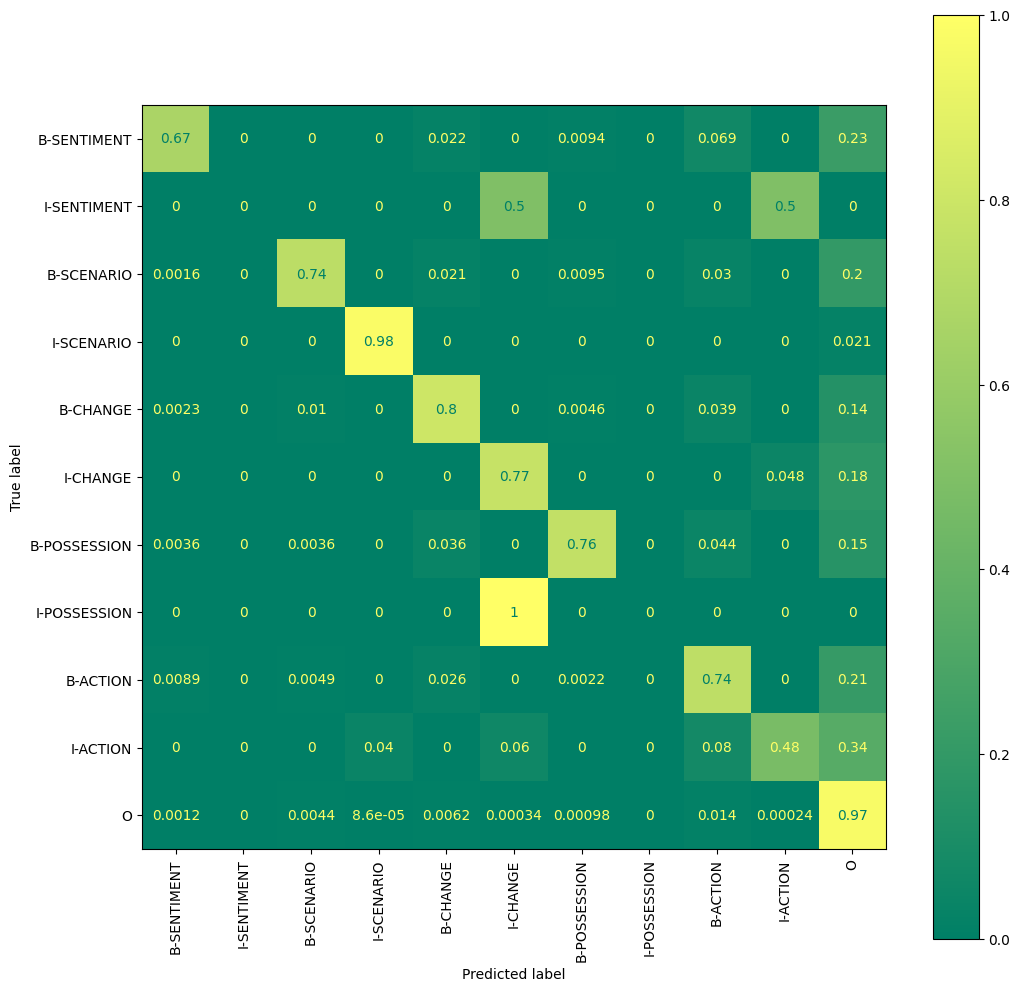

In [ ]:
# TEST
hparams = Hparams()
hparams.window_size = 40
hparams.window_shift = 40
vocab = json.load(open(hparams.vocab_path, "r"))

data_test = [json.loads(e) for e in open(hparams.data_test, "r")]
test_sentences = [e["tokens"] for e in data_test]
test_labels = [e["labels"] for e in data_test]
clean_tokens(test_sentences)
test_pos_tokens = None
if hparams.POS_emb:
    test_pos_tokens = pos_tagger(test_sentences)
    print("| TEST POS TAGS extracted! |\n")
test_dataset = EventDetDataset(test_sentences, test_labels, test_pos_tokens, vocab, hparams, pred=False)
test_dataloader = DataLoader(test_dataset, batch_size=hparams.batch_size, shuffle=False, num_workers=hparams.n_cpu, pin_memory=hparams.pin_memory, persistent_workers=True, collate_fn=EventDetDataset.collate_batch)

model = EventDetModel(hparams)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.load_state_dict(torch.load("/content/drive/MyDrive/NLP/HW_01/BEST/BEST.pth", map_location=device))
evaluation_pipeline(model, device, test_labels, test_sentences, test_dataloader, test_dataset.windows_each_sentence_list)